In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="2"

In [2]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from models import Cnet
from datasets import WSSBDatasetTest
from utils import od2rgb, rgb2od, random_ruifrok_matrix_variation, direct_deconvolution, peak_signal_noise_ratio

In [3]:
SAVE_IMAGES = True
RUNNING_ON_DELFOS = True

torch.manual_seed(0)
plt.rcParams['font.size'] = 14
plt.rcParams['toolbar'] = 'None'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
if RUNNING_ON_DELFOS:
    alsubaie_dataset_path = '/data/datasets/Alsubaie/Data/'
else:
    alsubaie_dataset_path = '../Alsubaie/Data/'

dataset = WSSBDatasetTest(alsubaie_dataset_path, organ_list=['Colon'], load_at_init=False)
original_image, M_gt = dataset[0]
print('Image shape:', original_image.shape)

[WSSBDataset] Scanning files...
[WSSBDataset] Done scanning files
Image shape: torch.Size([3, 500, 500])


In [6]:
# Generate all images derivated from the ground truth.

img_np = original_image.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
img_od = rgb2od(original_image)

C_gt = direct_deconvolution(img_od, M_gt)
M_gt = M_gt.unsqueeze(0) # (1, 3, 2)
C_gt = C_gt.unsqueeze(0) # (1, 2, 224, 224)

M_gt_rgb = torch.clamp(od2rgb(M_gt / np.log(256)), 0.0, 255.0) # (1, 3, 2)
M_gt_rgb_np = M_gt_rgb.squeeze().detach().cpu().numpy().transpose(1, 0).astype('int') # (2, 3)

C_H_gt_od = C_gt[:, 0, :, :].squeeze() # (224, 224)
C_H_gt = torch.clamp(od2rgb(C_H_gt_od), 0.0, 255.0)
C_H_gt_np = C_gt[:, 0, :, :].squeeze().numpy() # (224, 224)

C_E_gt_od = C_gt[:, 1, :, :].squeeze() # (224, 224)
C_E_gt = torch.clamp(od2rgb(C_E_gt_od), 0.0, 255.0)
C_E_gt_np = C_gt[:, 1, :, :].squeeze().numpy() # (224, 224)

H_gt_od = torch.einsum('bcs,bshw->bschw', M_gt, C_gt)[:,0,:,:] # (batch_size, H, W)
H_gt = torch.clamp(od2rgb(H_gt_od), 0.0, 255.0) # (batch_size, 3, H, W)
E_gt_od = torch.einsum('bcs,bshw->bschw', M_gt, C_gt)[:,1,:,:] # (batch_size, H, W)
E_gt = torch.clamp(od2rgb(E_gt_od), 0.0, 255.0) # (batch_size, 3, H, W)

H_gt_np = H_gt.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
E_gt_np = E_gt.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')

In [7]:
img_od = img_od.to(device)
H_gt = H_gt.to(device)
H_gt_od = H_gt_od.to(device)
E_gt = E_gt.to(device)
E_gt_od = E_gt.to(device)

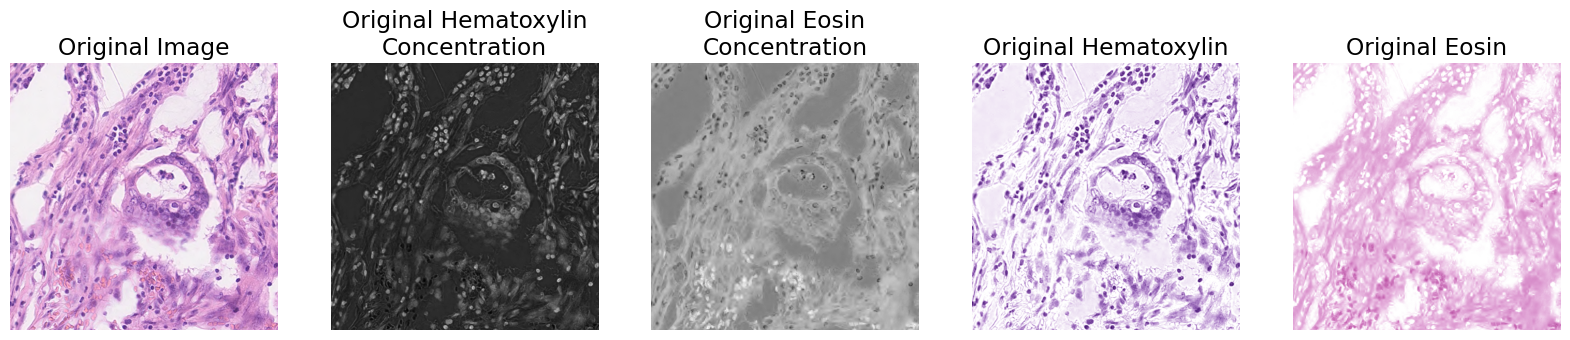

In [8]:
# Plot the ground truth images.
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

ax[0].imshow(img_np)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(C_H_gt_np, cmap='gray')
ax[1].set_title('Original Hematoxylin\nConcentration')
ax[1].axis('off')

ax[2].imshow(C_E_gt_np, cmap='gray')
ax[2].set_title('Original Eosin\nConcentration')
ax[2].axis('off')

ax[3].imshow(H_gt_np)
ax[3].set_title('Original Hematoxylin')
ax[3].axis('off')

ax[4].imshow(E_gt_np)
ax[4].set_title('Original Eosin')
ax[4].axis('off')

plt.show()

In [9]:
NUM_ITERATIONS = 5000
# Acceptable results in approximately 1000 epochs. \n
# It improves from there, but it does not finish converging and it goes pendulum.
# It is not profitable to use more than 4000-5000 iterations. Current minor loss in epoch=4800, see results' foler.

metrics_dict = { 
    'loss': 0.0, 'mse_rec' : 0.0, 'psnr_rec': 0.0,
    'mse_gt_h': 0.0, 'mse_gt_e': 0.0, 'mse_gt': 0.0,
    'psnr_gt_h': 0.0, 'psnr_gt_e': 0.0, 'psnr_gt': 0.0,
}

In [11]:
model = Cnet().to(device)
input_noise = torch.rand(original_image.shape).unsqueeze(0).to(device)  # Unsqueezed to add the batch dimension, it needs to be ([1, 3, x, y])
original_tensor = original_image.unsqueeze(0).to(device) 
_, _, H, W = original_tensor.shape               

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

start_time = time.time()
for epoch in range(NUM_ITERATIONS+1):
    optimizer.zero_grad()

    C_matrix = model(input_noise)

    # Generate the colors matrix as a sample of a gaussian distribution given the Ruifrok matrix
    h_matrix, e_matrix = random_ruifrok_matrix_variation(0.05)
    M_matrix = np.concatenate((h_matrix,e_matrix),axis=1)                   # ([1, 3, 2])
    M_matrix = torch.from_numpy(M_matrix).float().unsqueeze(0).to(device)   # ([1, 2, x, y])

    # Generate the 3 channels image and get it back to RGB
    reconstructed = torch.einsum('bcs,bshw->bchw', M_matrix, C_matrix)   # ([1, 3, x, y])
    metrics_dict['mse_rec'] = torch.sum(torch.pow(reconstructed - img_od, 2)).item() / (3.0*H*W)
    reconstructed = torch.clamp(od2rgb(reconstructed), 0, 255.0)              
    metrics_dict['psnr_rec'] += torch.sum(peak_signal_noise_ratio(reconstructed, original_tensor)).item()

    loss = torch.nn.functional.mse_loss(reconstructed, original_tensor)
    metrics_dict['loss'] = loss.item()
    loss.backward()
    optimizer.step()

    # Inteded to be used in a script, and not in a Jupyter, since it does not update the graph but regenerates it in the cell output. For the moment I'm just saving it.
    if epoch % 200 == 0:

        # Generate the images from the model
        C_mean = C_matrix.detach().cpu()
        img_rec_np = reconstructed.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
        
        C_H_rec_od = C_mean[:, 0, :, :].squeeze() 
        C_H_rec = torch.clamp(od2rgb(C_H_rec_od), 0.0, 255.0)
        C_H_rec_np = C_mean[:, 0, :, :].squeeze().numpy() 
        C_E_rec_od = C_mean[:, 1, :, :].squeeze()
        C_E_rec = torch.clamp(od2rgb(C_E_rec_od), 0.0, 255.0)
        C_E_rec_np = C_mean[:, 1, :, :].squeeze().numpy()

        H_rec_od = torch.einsum('bcs,bshw->bschw', M_matrix, C_matrix)[:,0,:,:] 
        H_rec = torch.clamp(od2rgb(H_rec_od), 0.0, 255.0) 
        E_rec_od = torch.einsum('bcs,bshw->bschw', M_matrix, C_matrix)[:,1,:,:]
        E_rec = torch.clamp(od2rgb(E_rec_od), 0.0, 255.0)

        H_rec_np = H_rec.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')
        E_rec_np = E_rec.squeeze().detach().cpu().numpy().transpose(1, 2, 0).astype('uint8')

        
        metrics_dict['mse_gt_h'] += torch.sum(torch.pow(H_gt_od - H_rec_od, 2)).item() / (3.0*H*W)
        metrics_dict['mse_gt_e'] += torch.sum(torch.pow(E_gt_od - E_rec_od, 2)).item() / (3.0*H*W)

        metrics_dict['psnr_gt_h'] += torch.sum(peak_signal_noise_ratio(H_gt, H_rec)).item()
        metrics_dict['psnr_gt_e'] += torch.sum(peak_signal_noise_ratio(E_gt, E_rec)).item()

        metrics_dict['mse_gt'] = (metrics_dict['mse_gt_h'] + metrics_dict['mse_gt_e'])/2.0
        metrics_dict['psnr_gt'] = (metrics_dict['psnr_gt_h'] + metrics_dict['psnr_gt_e'])/2.0

        with open('/home/modej/Deep_Var_BCD/results/dip_images/metricas.txt', 'a') as archivo:
            archivo.write(f"Epoch: {epoch}\n")
            for key in metrics_dict:
                archivo.write(f"{key} -> {metrics_dict[key]}\n")
            archivo.write("\n")

        if SAVE_IMAGES:
            # Plot the ground truth images
            fig, ax = plt.subplots(2, 5, figsize=(20, 9))

            ax[0,0].imshow(img_np)
            ax[0,0].set_title('Original Image')
            ax[0,0].axis('off')

            ax[0,1].imshow(C_H_gt_np, cmap='gray')
            ax[0,1].set_title('Original Hematoxylin\nConcentration')
            ax[0,1].axis('off')

            ax[0,2].imshow(C_E_gt_np, cmap='gray')
            ax[0,2].set_title('Original Eosin\nConcentration')
            ax[0,2].axis('off')

            ax[0,3].imshow(H_gt_np)
            ax[0,3].set_title('Original Hematoxylin')
            ax[0,3].axis('off')

            ax[0,4].imshow(E_gt_np)
            ax[0,4].set_title('Original Eosin')
            ax[0,4].axis('off')

            # Plot the generated images via the model
            ax[1,0].imshow(img_rec_np)
            ax[1,0].set_title('Reconstructed Image')
            ax[1,0].axis('off')

            ax[1,1].imshow(C_H_rec_np, cmap='gray')
            ax[1,1].set_title('Reconstructed Hematoxylin\nConcentration')
            ax[1,1].axis('off')

            ax[1,2].imshow(C_E_rec_np, cmap='gray')
            ax[1,2].set_title('Reconstructed Eosin\nConcentration')
            ax[1,2].axis('off')

            ax[1,3].imshow(H_rec_np)
            ax[1,3].set_title('Reconstructed Hematoxylin')
            ax[1,3].axis('off')

            ax[1,4].imshow(E_rec_np)
            ax[1,4].set_title('Reconstructed Eosin')
            ax[1,4].axis('off')
            
            if RUNNING_ON_DELFOS:
                plt.savefig(f'/home/modej/Deep_Var_BCD/results/dip_images/{epoch}.png', transparent=True)
            else:
                plt.savefig(f'/home/modejota/Deep_Var_BCD/results/dip_images/{epoch}.png', transparent=True)
            plt.close()

end_time = time.time()
execution_time = end_time - start_time
# Should be executed without generating images to be a valid benchmark of the model/method itself.
with open('/home/modej/Deep_Var_BCD/results/dip_images/metricas.txt', 'a') as archivo:
    archivo.write(f"Execution time: {execution_time} seconds")